Welcome to the hands-on lab for **CI/CD with OpenShift Pipelines**. In this lab, you will create a CI/CD workflow using the OpenShift Pipelines.

# Learning Objectives

After completing this lab, you will be able to:
* Create a CI/CD workflow using the OpenShift Pipelines
* Add parameters to tasks created using OpenShift Pipelines
* Add a workspace and persistant volume claim in the OpenShift UI
* Add tasks that clone the GitHub repository, lint the source code, run unit tests and finally deploy the application to the OpenShift cluster

# Set Up the Lab Environment

In the terminal, if you are not already in the /home/project folder, change to your project folder now.
```
cd /home/project
```

You can use the following command to ensure you are connected to an OpenShift cluster:
```
oc config current-context
```

You should see something like:
```
captainfedo1-context
```

You are now ready to continue installing the **Prerequisites**.

# Prerequisites

* This lab requires installation of the tasks introduced in the previous labs. 
* To be sure, apply the previous tasks to your cluster before proceeding. 
* Reissue these commands.

## Establish the Tasks

First create an empty file called `tasks.yaml` in the root folder:
```
touch tasks.yaml
```

Open the `tasks.yaml` file and add the following yaml content.

```
---
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: cleanup
spec:
  description: This task will clean up a workspace by deleting all the files.
  workspaces:
    - name: source
  steps:
    - name: remove
      image: alpine:3
      env:
        - name: WORKSPACE_SOURCE_PATH
          value: $(workspaces.source.path)
      workingDir: $(workspaces.source.path)
      securityContext:
        runAsNonRoot: false
        runAsUser: 0
      script: |
        #!/usr/bin/env sh
        set -eu
        echo "Removing all files from ${WORKSPACE_SOURCE_PATH} ..."
        # Delete any existing contents of the directory if it exists.
        #
        # We don't just "rm -rf ${WORKSPACE_SOURCE_PATH}" because ${WORKSPACE_SOURCE_PATH} might be "/"
        # or the root of a mounted volume.
        if [ -d "${WORKSPACE_SOURCE_PATH}" ] ; then
          # Delete non-hidden files and directories
          rm -rf "${WORKSPACE_SOURCE_PATH:?}"/*
          # Delete files and directories starting with . but excluding ..
          rm -rf "${WORKSPACE_SOURCE_PATH}"/.[!.]*
          # Delete files and directories starting with .. plus any other character
          rm -rf "${WORKSPACE_SOURCE_PATH}"/..?*
        fi

---
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: nose
spec:
  workspaces:
    - name: source
  params:
    - name: args
      description: Arguments to pass to nose
      type: string
      default: "-v"
  steps:
    - name: nosetests
      image: python:3.9-slim
      workingDir: $(workspaces.source.path)
      script: |
        #!/bin/bash
        set -e
        python -m pip install --upgrade pip wheel
        pip install -r requirements.txt
        nosetests $(params.args)
```

Make sure you save the file. 

Next, apply the tasks to your OpenShift Cluster: `kubectl apply -f tasks.yaml`

Check that you have all of the previous tasks installed: `oc get tasks`

You should see the output similar to this:

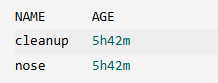

# Step 1: Create PersistentVolumeClaim

You also need a PersistentVolumeClaim (PVC) to use as a workspace. You can use the OpenShift Administrator perspective to create the PVC.

Open the OpenShift console using the **Open OpenShift Console** under the **Skills Network Toolbox** menu.

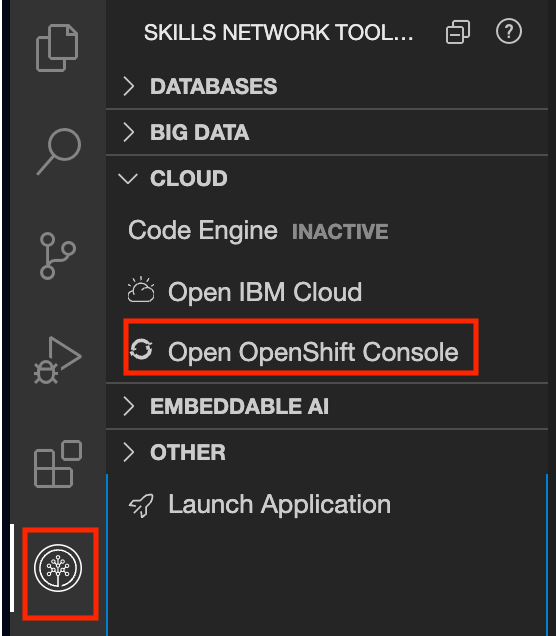

The lab should open the **Developer** perspective for the OpenShift console in a new tab.

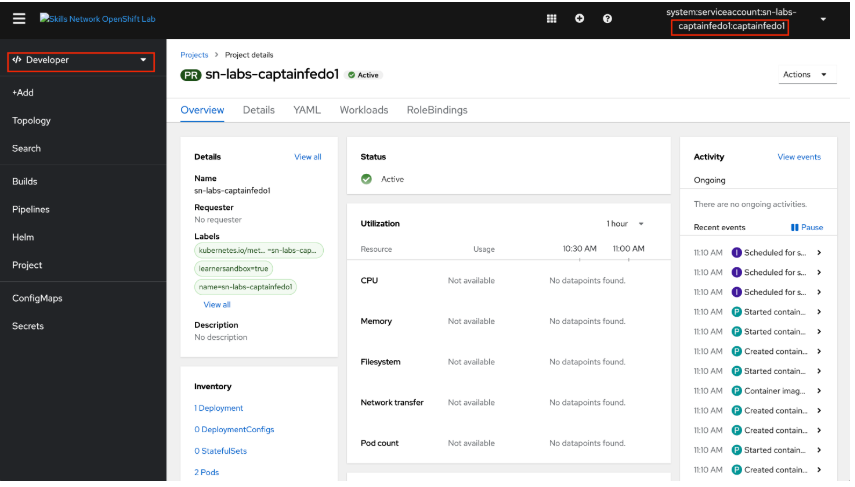

Open the **Administrator** perspective using the drop down on the left side of the screen.

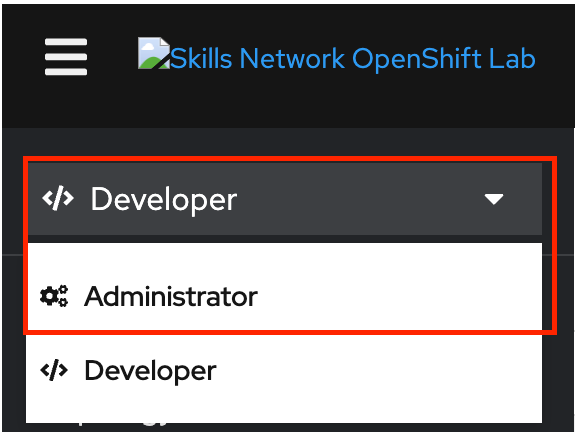

Once the page switches to the **Administrator** view, click **Storage** and **PersistantVolumeClaims**.

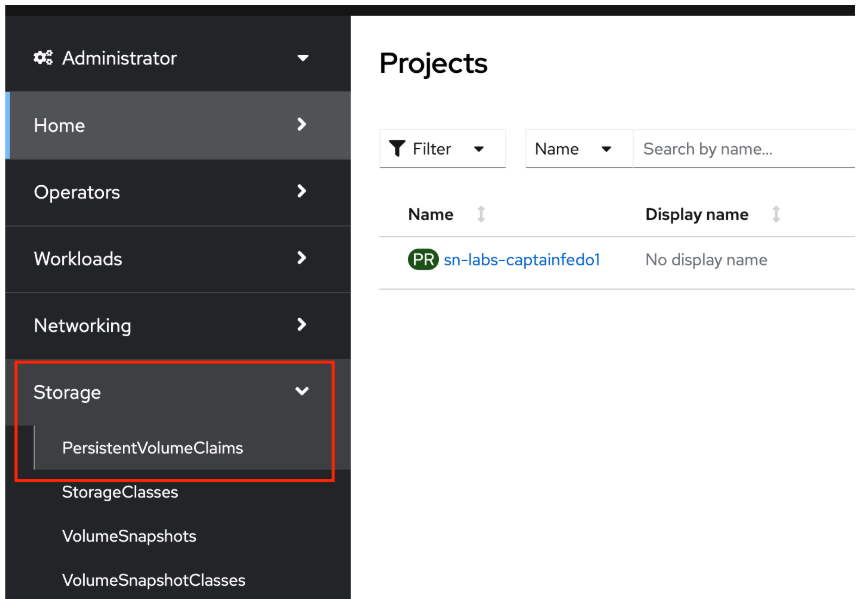

> ***Note:** If you encounter an error when opening OpenShift and accessing the Persistent Claim value, please close the OpenShift window and then reopen it*.

Click `Create PersistentVolumeClaim` to create a new PVC:

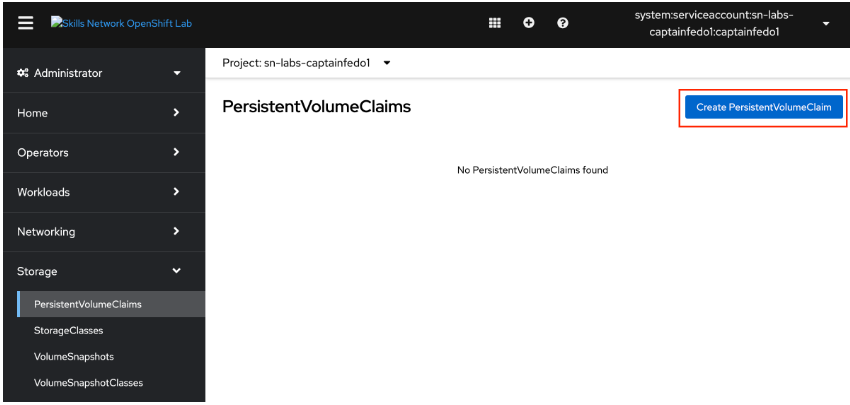

Next, fill out the form as follows:
* **StorageClass: `skills-network-learner`**
* **PersistantVolumenClaim name: `oc-lab-pvc`**
* **Size: `1GB`**

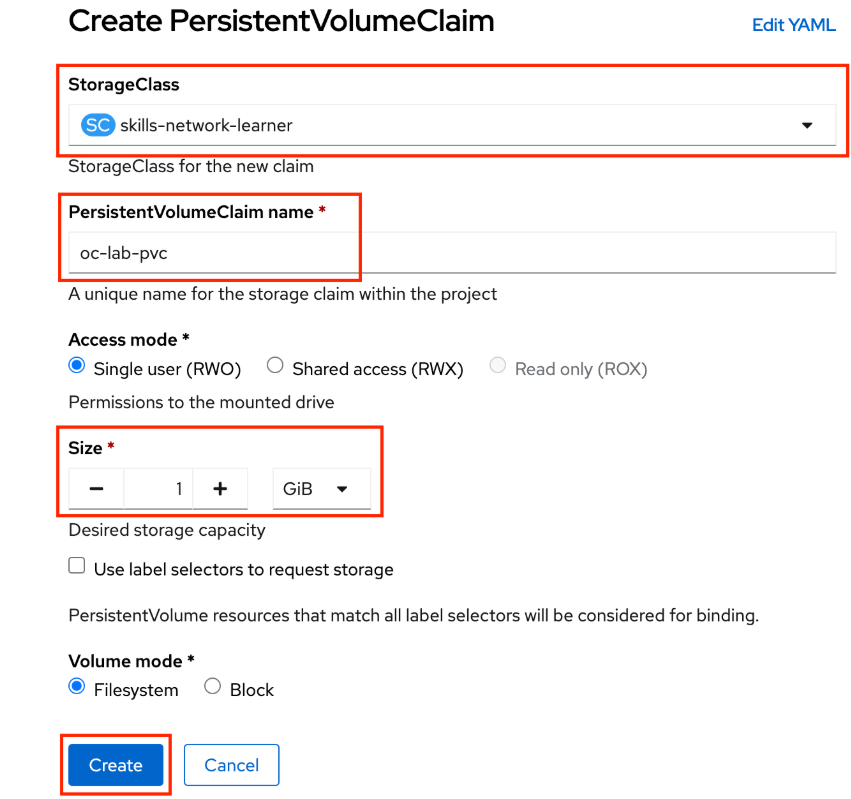

Finally, click `Create` to create the PVC. Once the PVC is created, you should see the details. Notice the **Status** is **Pending**. It takes a few minutes for the PVC to complete. You don't have to wait for this to finish as it will most likely be in place by the time you need it in the pipeline.

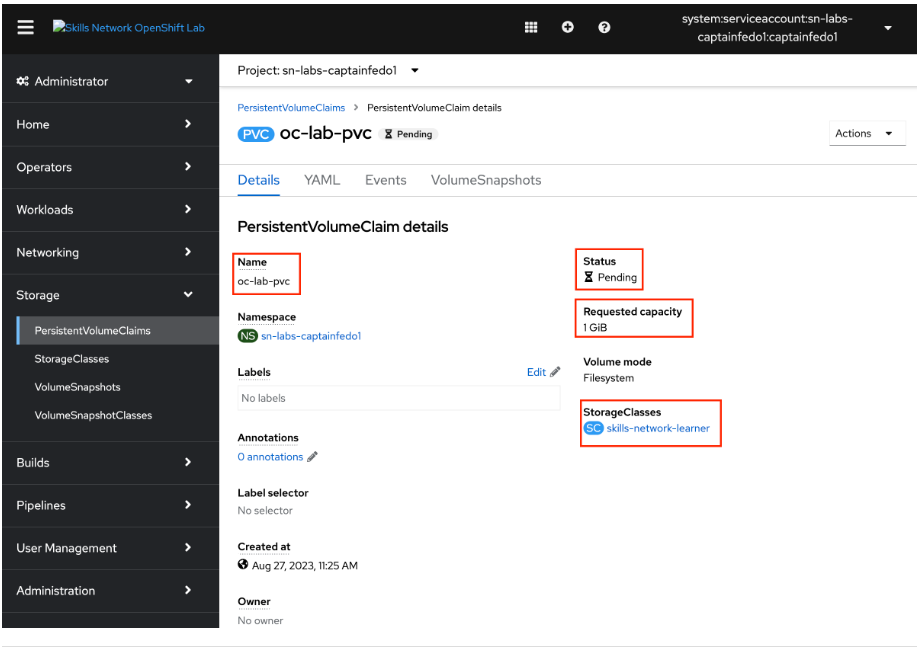

# Step 2: Create a new Pipeline

Now that you have a PVC in place, the next step is start working on the pipeline. First, go back to the **Developer** perspective

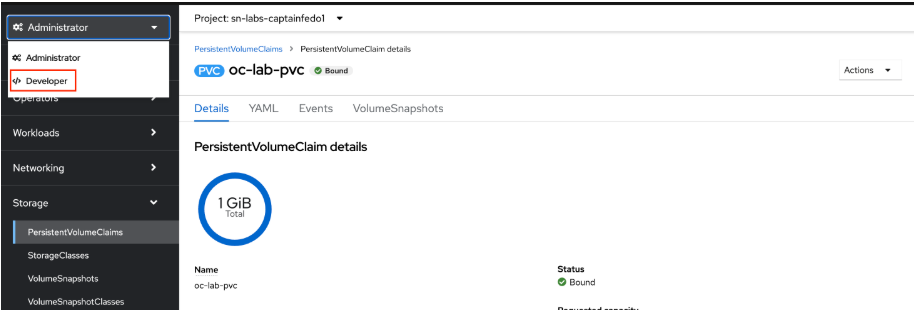

Next, click **Pipelines** on the left panel and create a new pipeline.

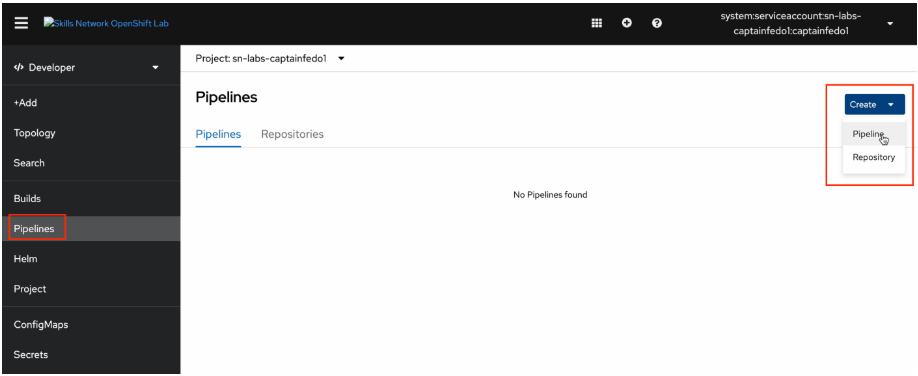

You are presented with the pipeline builder. Ensure you have **Pipeline Builder** selected in **Configure Via** and enter `ci-cd-pipeline` as the name of your pipeline.

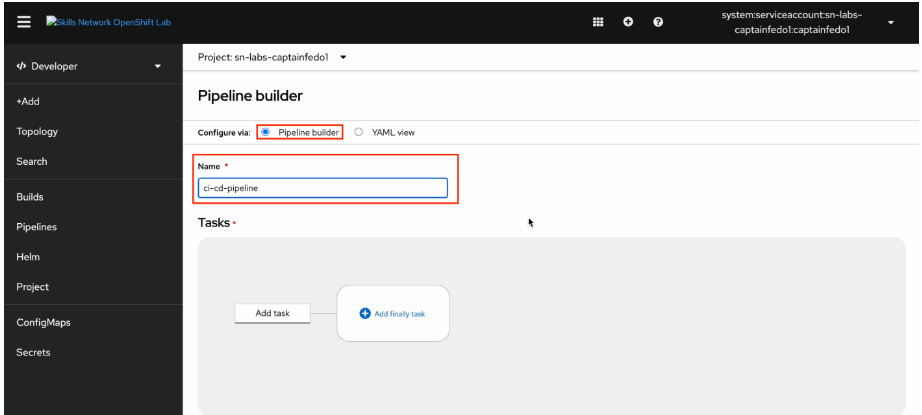

Before you create your first task, let's add a workspace to your pipeline. Scroll to the bottom of the page and add a new workspace with the name `output`. This workspace will be used to clone the code.

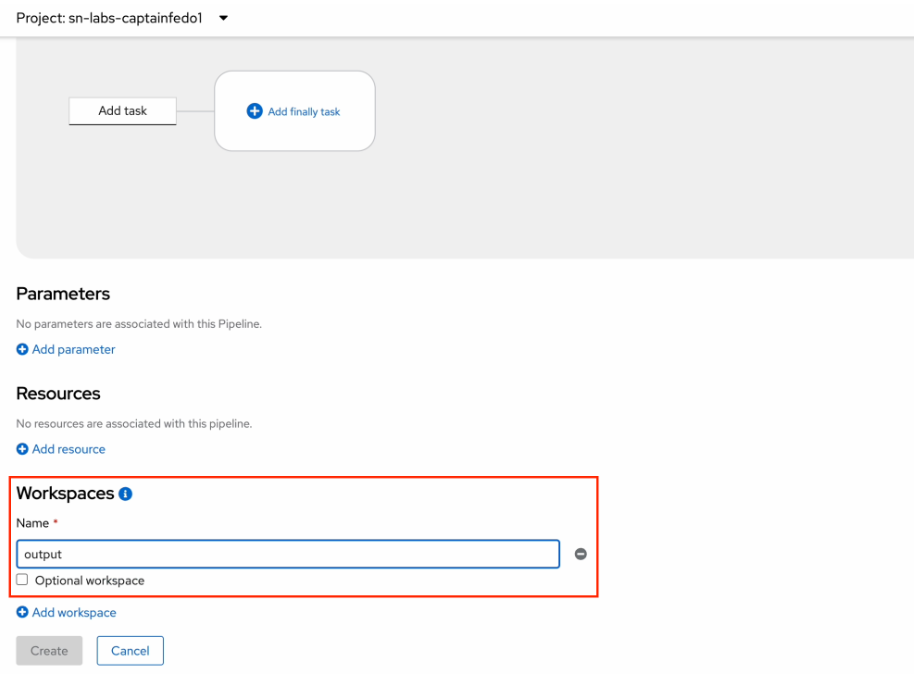

**Great!** We can now start adding tasks to your pipeline.

# Step 3: Add the cleanup task

You were asked to apply a `tasks.yaml` file that contained the `cleanup` and the `nose` tasks. You can confirm the tasks are installed by using the following command: `oc get tasks`

You should see the output similar to this:

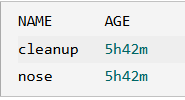

If you don't see both of these tasks, go back to the `Preqrequisites` step and make sure you apply the `tasks.yaml` file.

You will create the first task in this step. Click **Add Task** in the builder UI to open the `Add task ...` dialog.

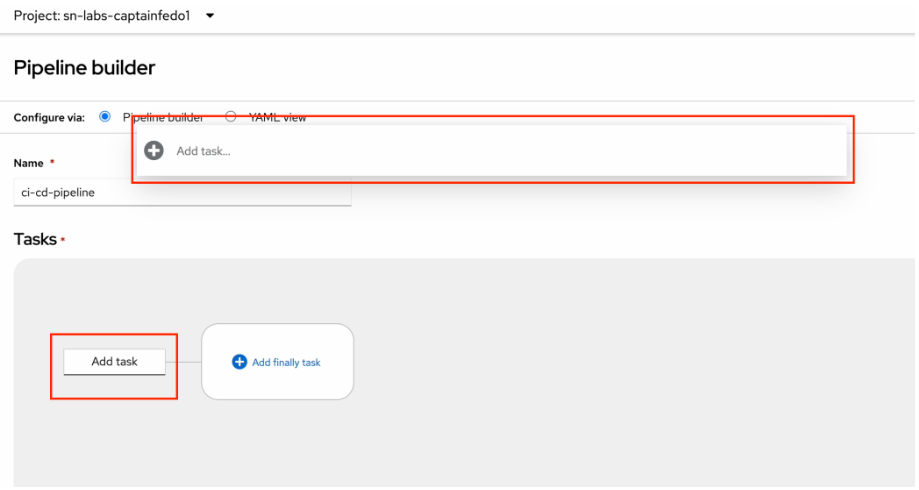

Type `cleanup` to see the task you installed earlier from the yaml file. Click `Add` to use the task in the builder.

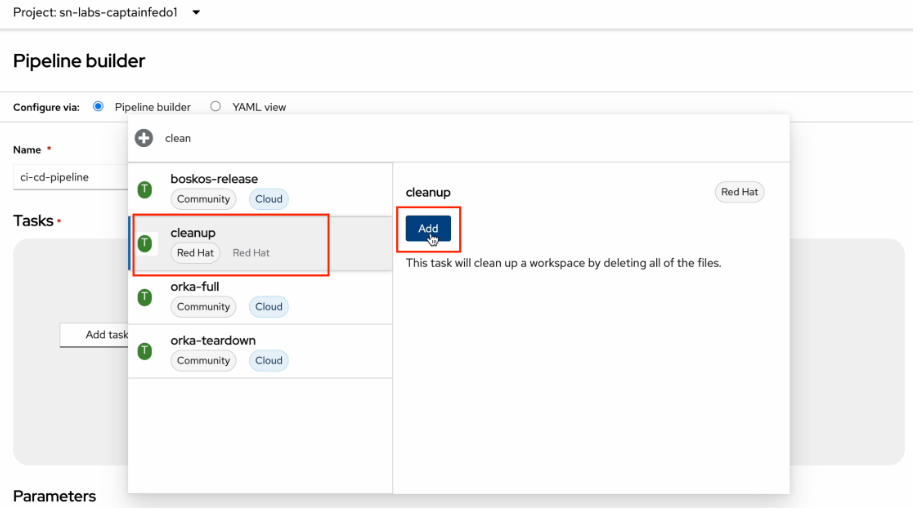

This should install your first task. You will notice the red exclamation mark on the task. This means the task has not been completely configured yet. Click on the task to open the task flyout. Change the workspace to **output**.

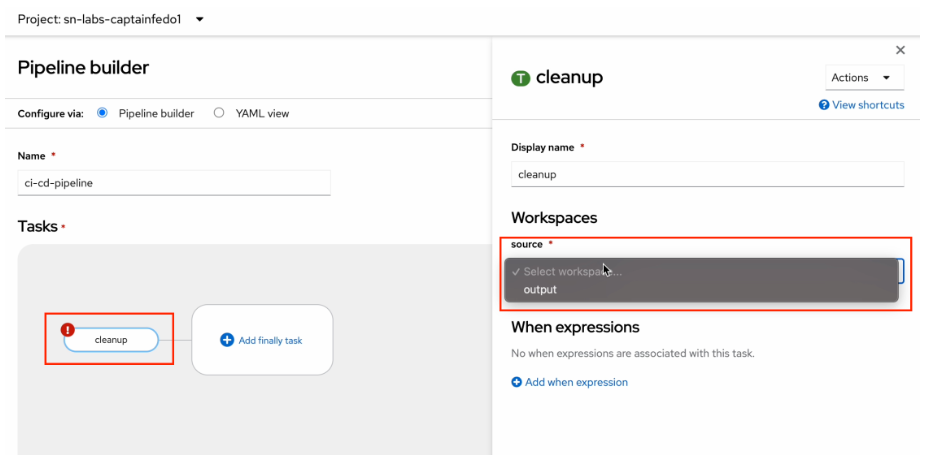

You should see the exclamation mark go away and **Create** enabled. Click **Create** to finish creating the task in the pipeline.

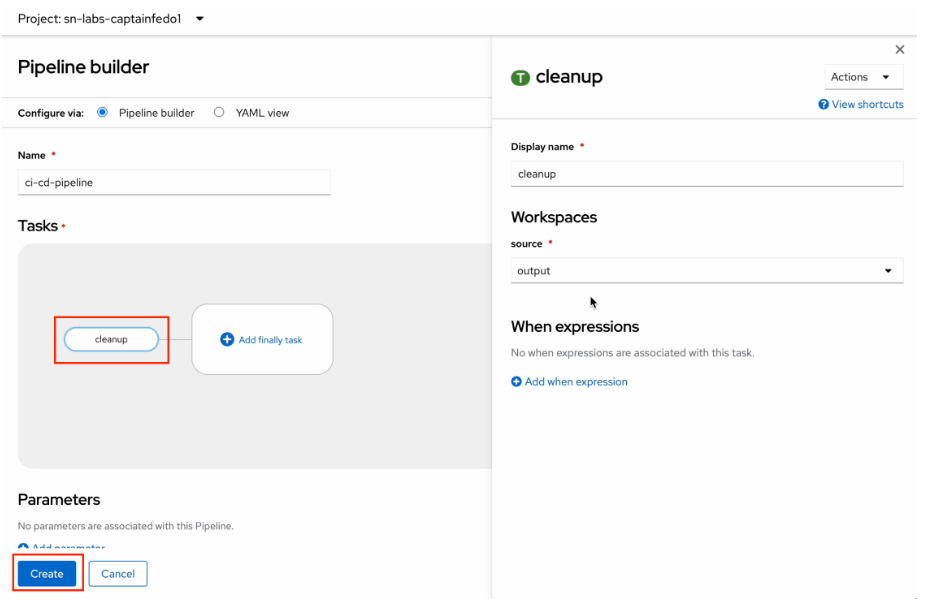

You should now see your pipeline with the one task you just added.

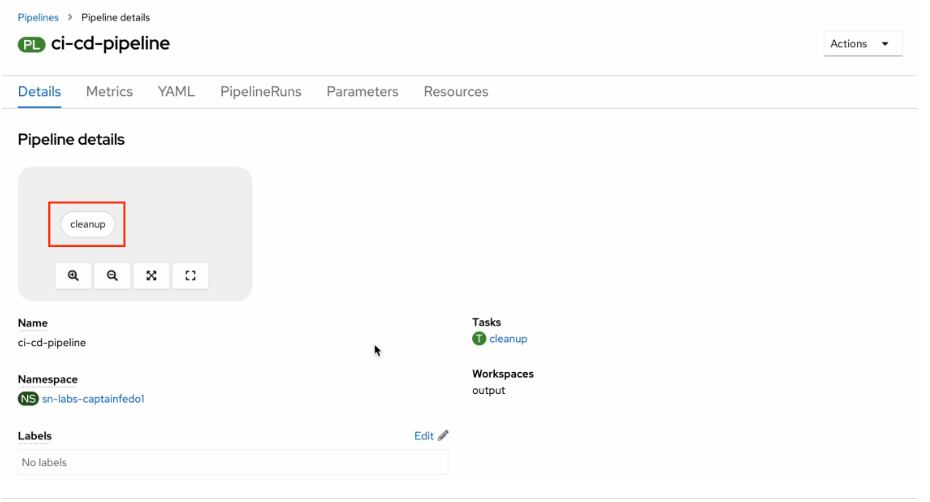

# Step 4: Run the Pipeline

Now that you have a pipeline with the one cleanup step, let's see how you can run this pipeline. Click `Pipelines` on the left bar, if you are not already on the pipelines page. Click on `ci-cd-pipeline pipeline`. You can now use the `Actions` dropdown on the left to run the pipeline.

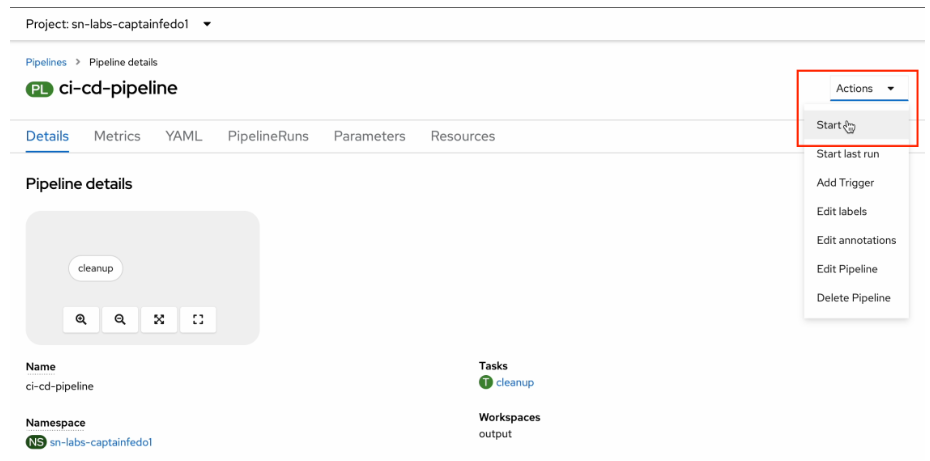

OpenShift brings up the **Start Pipeline** dialog box. Ensure that you pick the following:
* output: `PersistentVolumeClaim`
* select a PVC: `oc-lab-pvc`

Click **Start** after you have filled out the form.

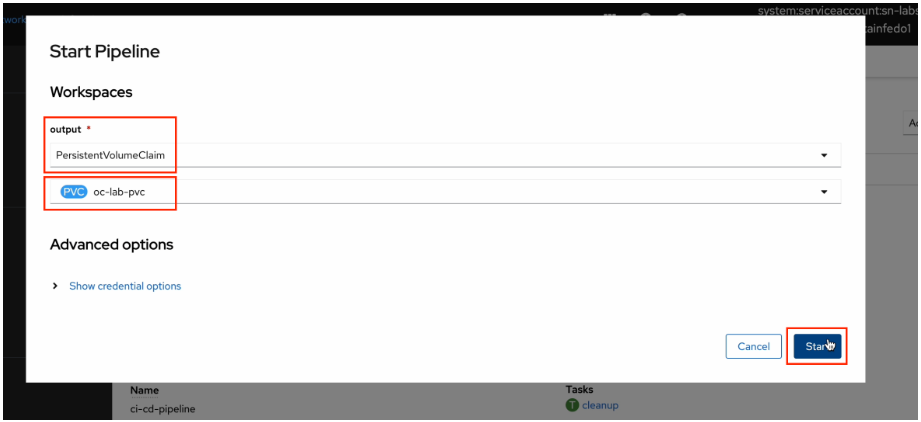

You should see the pipeline running on the next page. You can click on the task name to see the logs for a particular task. Alternatively, you can click on the **Logs** tab:

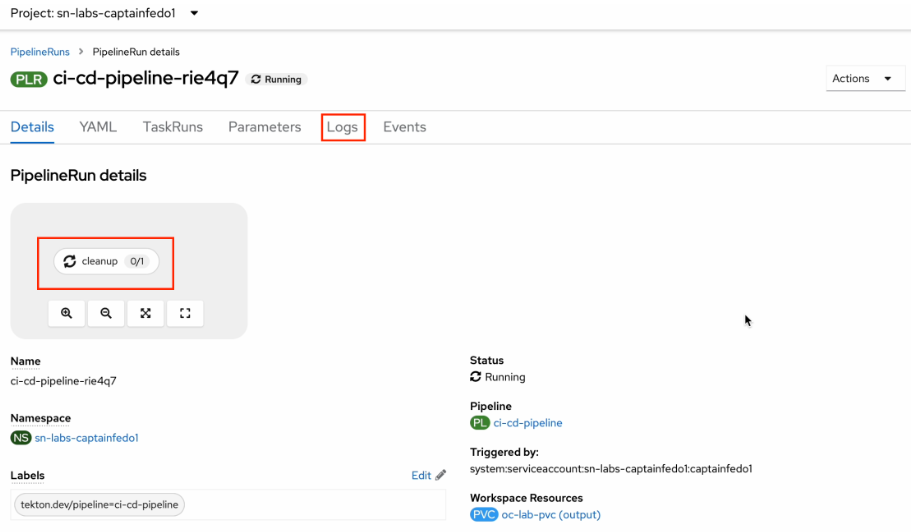

You can see the detailed logs and also have an option to download them. You will see the task on the right turn green, if it completes successfully.

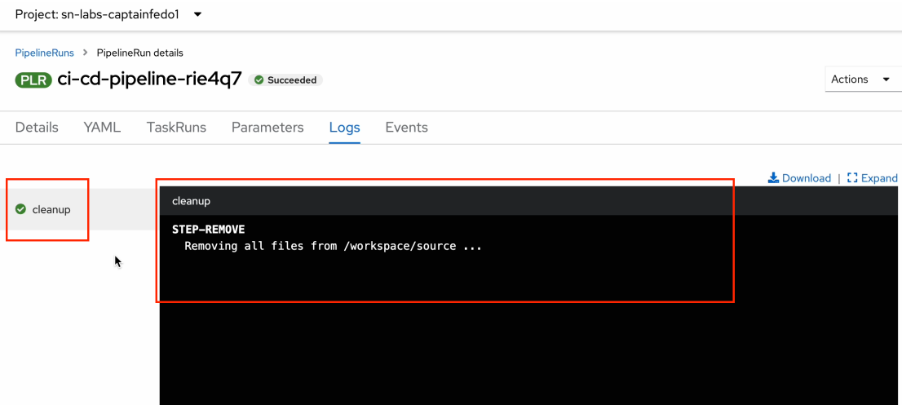

**Congratulations!** 

You created a pipeline from scratch and added the cleanup tasks on it. You then ran the pipeline and viewed the logs. This first task was explained in detail as an example. The lab is now asking you to finish the rest of the tasks in this pipeline on your own. Don't worry! You will be given appropriate hints and you have the option of reaching out to your peers or course TAs in the forums if you get stuck. **Good luck!**

# Step 5: Add the Git Clone task

You are asked to use the `git-clone` in-built task to clone the GitHub code into your pipeline.

## Your Task

1. Open the pipeline in edit mode. Select Pipeline from the left menu, select the pipeline name, and the go to `Actions -> Edit Pipeline`. See hint for a screenshot.
2. Add a new task after the cleanup task in the pipeline from previous step. Hover over the step to display the `+` buttons. Use the `+` button on the right of the task to add a task instead of using the `Add finally task` link. See hint for a screenshot.
3. Look for the RedHat `git-clone` task and add it to the placeholder task.
4. Click on the red exclaimation on the task or the task card to open the configure task flyout. Configure the `git-clone` task as follows:
    * **url:** `https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode`
    * **workspace.output:** `output`
5. Save the pipeline.
6. Run the pipeline.
7. Check the logs to see if there are issues with the pipeline.

## Hint

1. To open a pipeline in edit mode, select Pipeline from the left menu, select the pipeline name, and the go to `Actions -> Edit Pipeline`.

    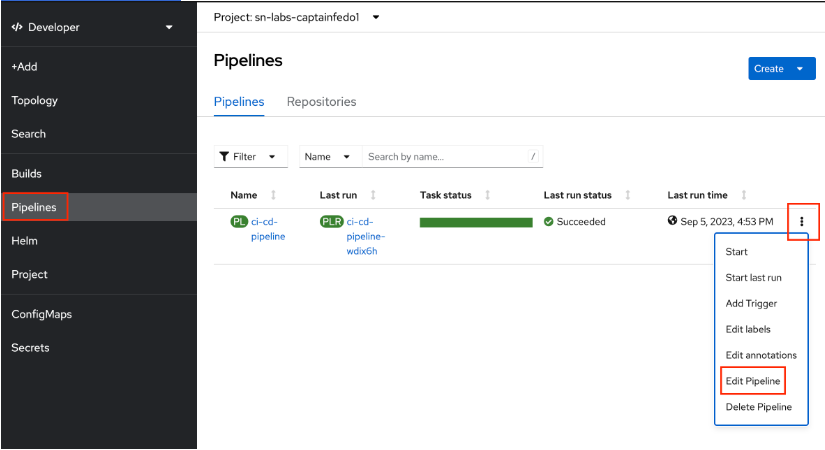

2. When adding a task, use the `+` button to create a new task block. The `+` button only appear if you hover over the previous task.

    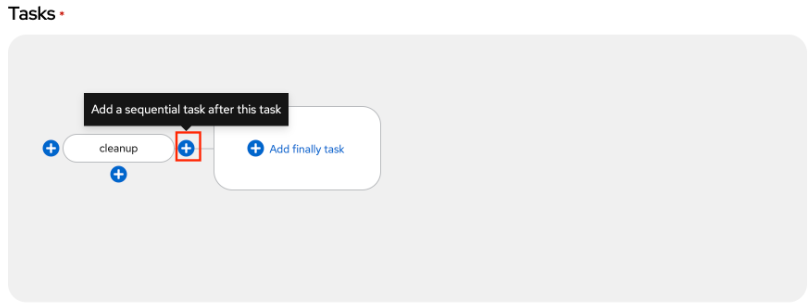

    This should create an empty block. Click on the block and fill in the task.

    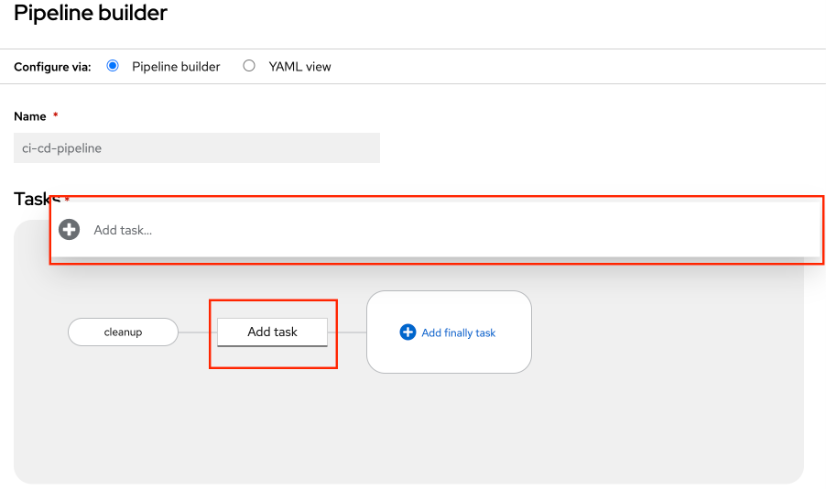

3. There could be multiple tasks called `git-clone` in the task search dialog. Ensure that you pick the one by Redhat.

    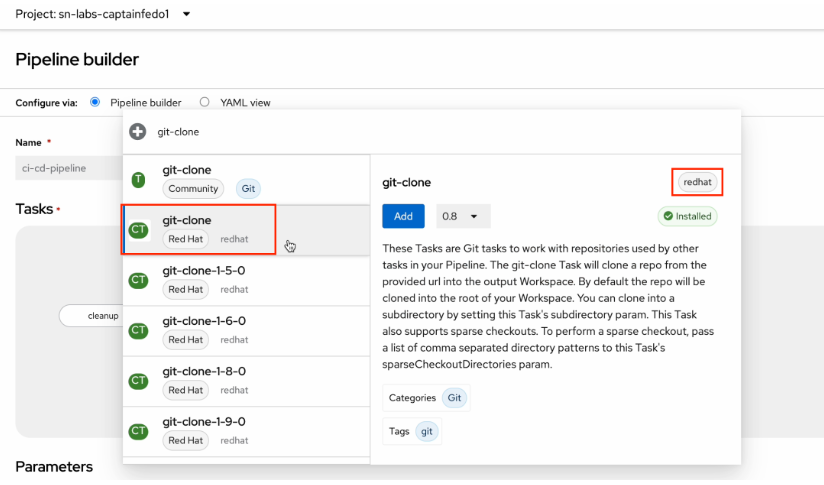

4. Click on the exclamation mark to open the task flyout. You should fill it out as follows:

   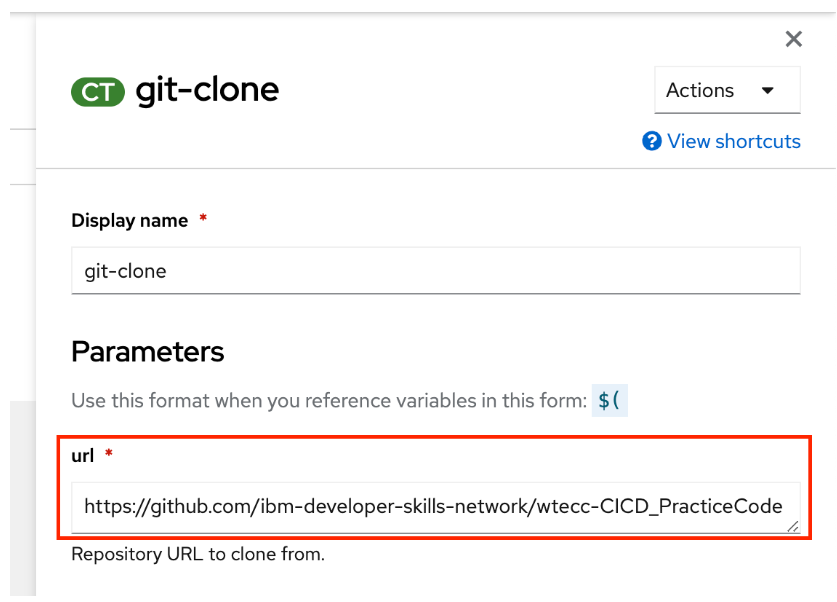

## Check your Solution

If the pipeline ran successfully, you should see both tasks in green in the logs tab:

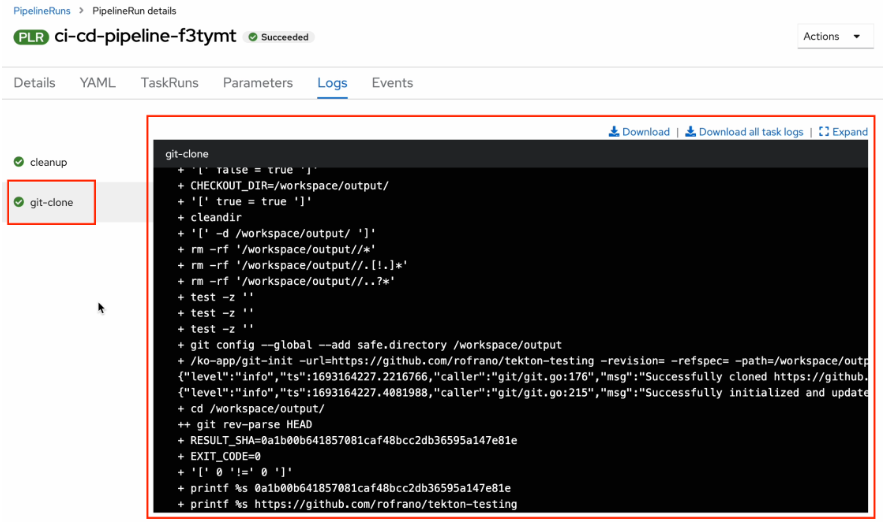

If you complete the task successfully, your pipeline should look as follows:

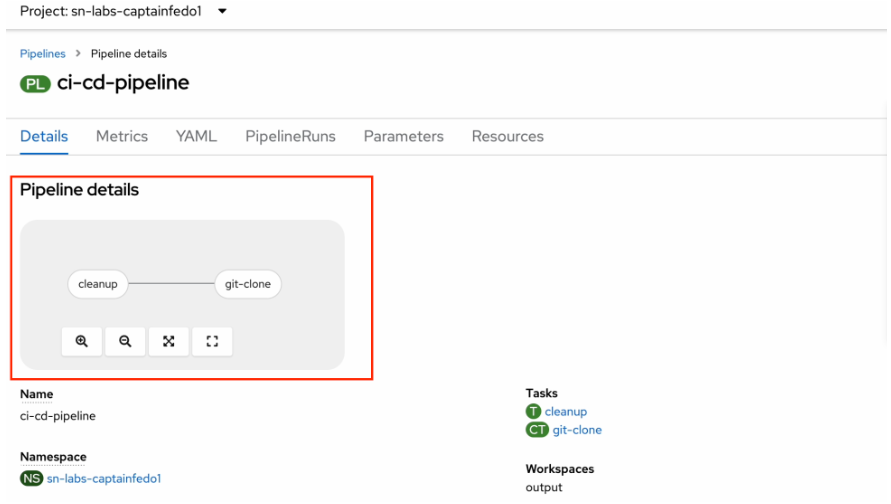

# Step 6: Add the Flake8 task

You are asked to use the `Flake8` in-built task to lint the source code. As part of this task, you will configure the task with specific arguments.

## Your Task

1. Open the pipeline in edit mode.
2. Add a new task after the git-clone task in the pipeline from previous step.
3. Look for the `Flake8` task from the community.
4. Install and add it to the placeholder task.
5. Click on the red exclaimation on the task or the task card to open the configure task flyout. Configure the `Flake8` task as follows:
    * **image:** `python:3.9-slim`
    * **arg:** `--count`
    * **arg:** `--max-complexity=10`
    * **arg:** `--max-line-length=127`
    * **workspace.source:** `output`
6. Save the pipeline.
7. Run the pipeline.
8. Check the logs to see if there are issues with the pipeline.

## Hint

Ensure the configuration is as follows:

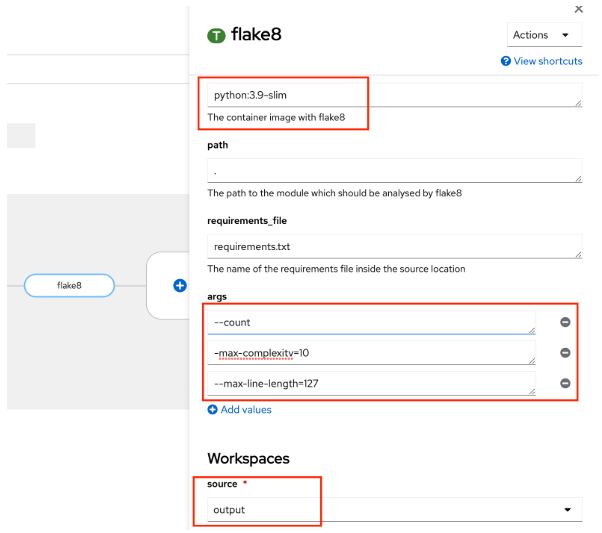

## Check your Solution

If the pipeline ran successfully, you should see both tasks in green in the logs tab:

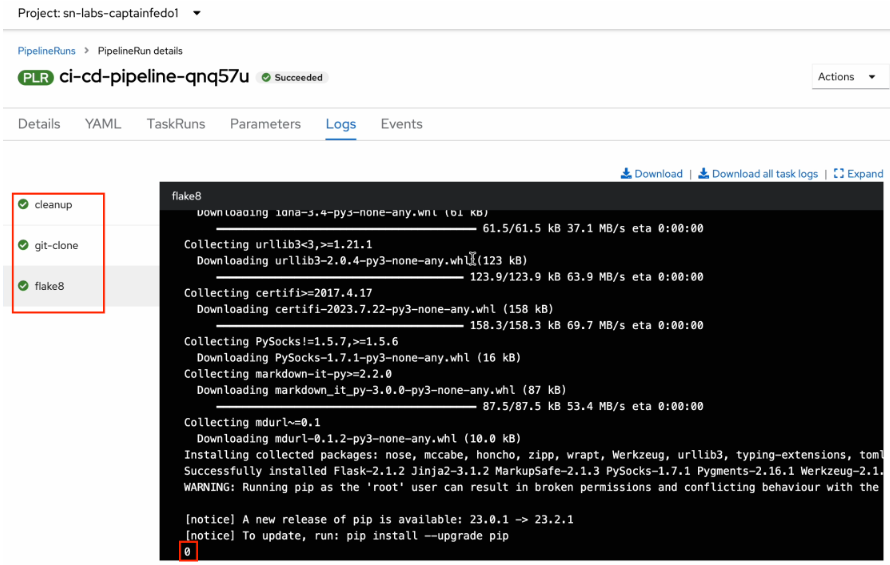

If you complete the task successfully, your pipeline should look as follows:

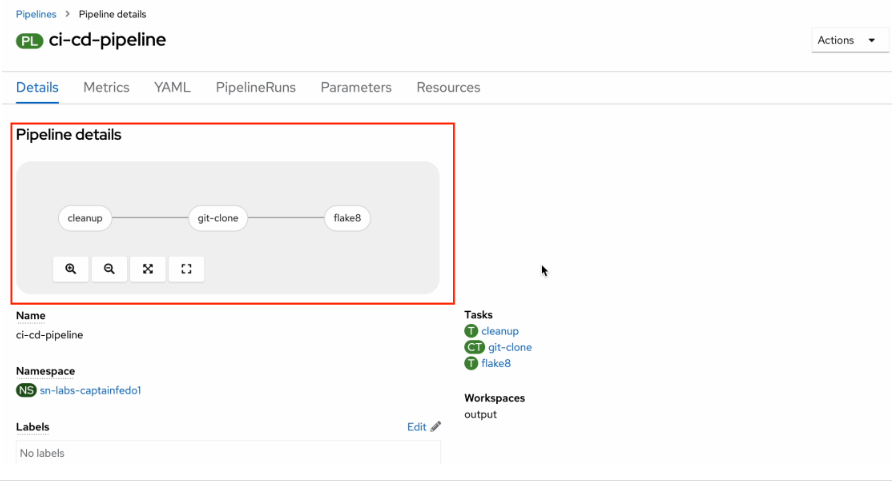

# Step 7: Add the Nose task

The next step is to add the `nose` task for unit testing the source code of the application.

## Your Task

1. Open the pipeline in edit mode.
2. Add a new task after the Flake8 task in the pipeline from previous step.
3. Look for the `nose` task.
4. Install and add it to the placeholder task.

> **Note:** *If you encounter an error stating: missing workspaces, kindly run the following command in the terminal window to install flake8: `tkn hub install task flake8`*

You should then see this:

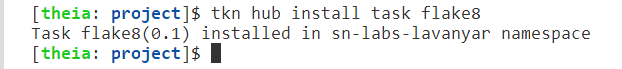

5. Click on the red exclaimation on the task or the task card to open the configure task flyout. Configure the `nose` task as follows:
    * `workspace.source: output`
6. Save the pipeline.
7. Run the pipeline.
8. Check the logs to see if there are issues with the pipeline.

## Check your Solution

If the pipeline ran successfully, you should see all tasks in green in the logs tab. You should also see the output from the `nose` task indicating all tests have passed successfully.

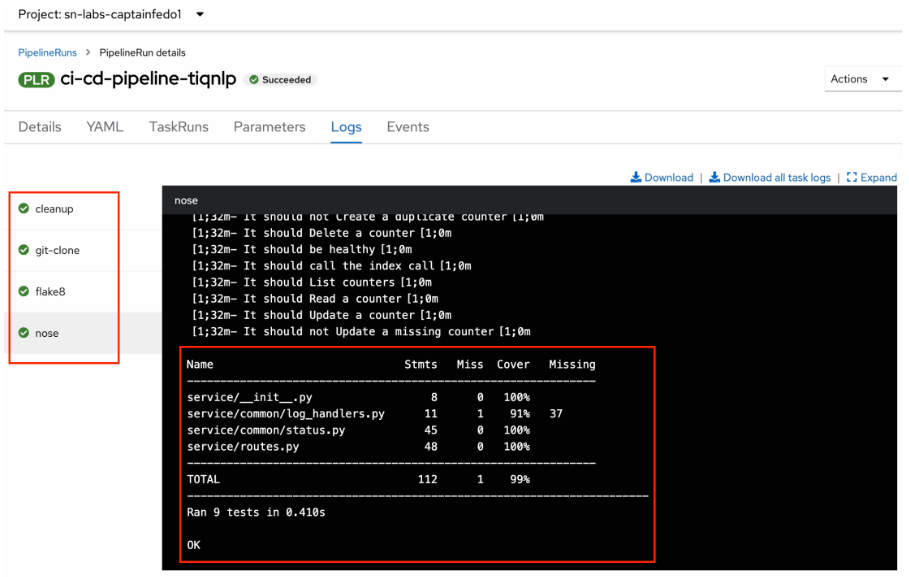

If you complete the task successfully, your pipeline should look as follows:

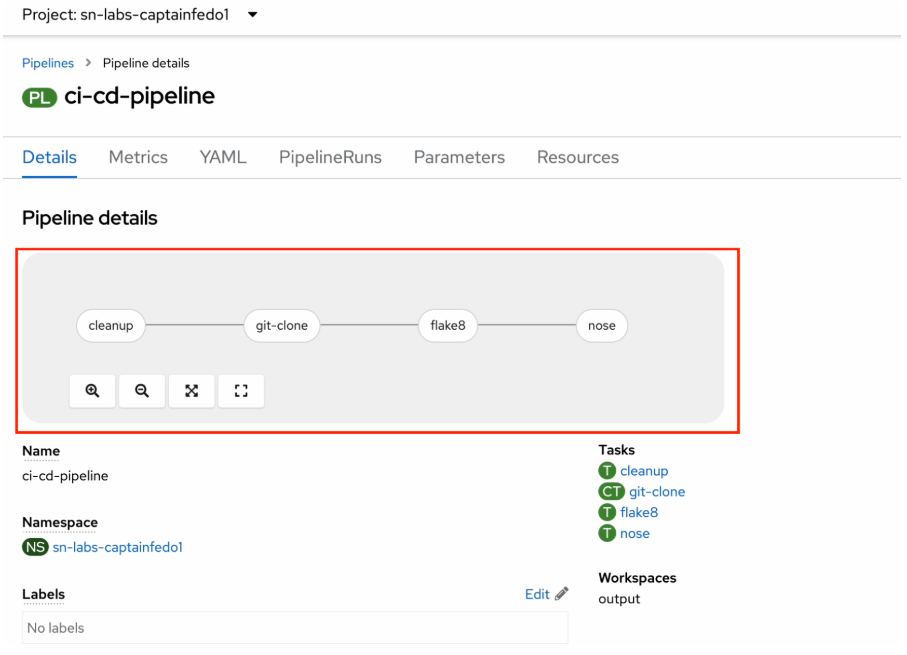

# Step 8: Add the buildah task

The next step is to add a task to create an image from the GitHub source code. 

You will use the `buildah` in-built task to perform this action.

## Your Task

1. Open the pipeline in edit mode.
2. Add a new task after the nose task in the pipeline from previous step.
3. Look for the `buildah` task from RedHat.
4. Install and add it to the placeholder task.
5. You will need the namespace of your lab environment for one of the arguments. You can obtain this by using the command line terminal and using the echo `$SN_ICR_NAMESPACE` command in the lab terminal.
```
echo $SN_ICR_NAMESPACE
```

6. Click on the red exclaimation on the task or the task card to open the configure task flyout. Configure the `buildah` task as follows:
* **image: `$(params.build-image)`**
* **workspace.source: `output`**

7. Click on the main page to close the flyout. Add the following parameter and the default value to the pipeline:
    * parameter.name: `build-image`
    * parameter.default: `image-registry.openshift-image-registry.svc:5000/SN_ICR_NAMESPACE/tekton-lab:latest`.
    * Replace `SN_ICR_NAMESPACE` with the value above.
8. Save the pipeline.
9. Run the pipeline.
10. Check the logs to see if there are issues with the pipeline.

## Hint

1. Ensure you filled out the `IMAGE` parameter with `$(params.build-image)`.

    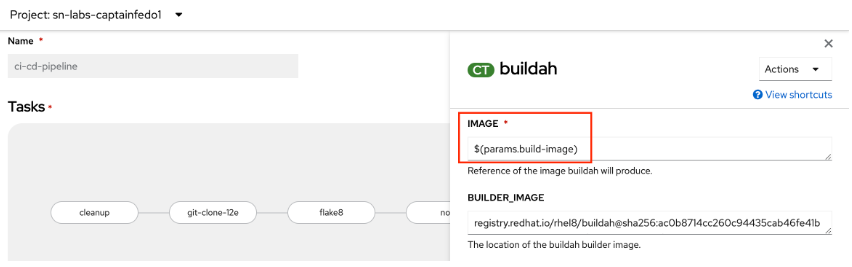
   
2. Create a pipeline parameter with the name `build-image` and the default value `image-registry.openshift-image-registry.svc:5000/SN_ICR_NAMESPACE/tekton-lab:latest` where `SN_ICR_NAMESPACE` is namespace of your lab environment.

    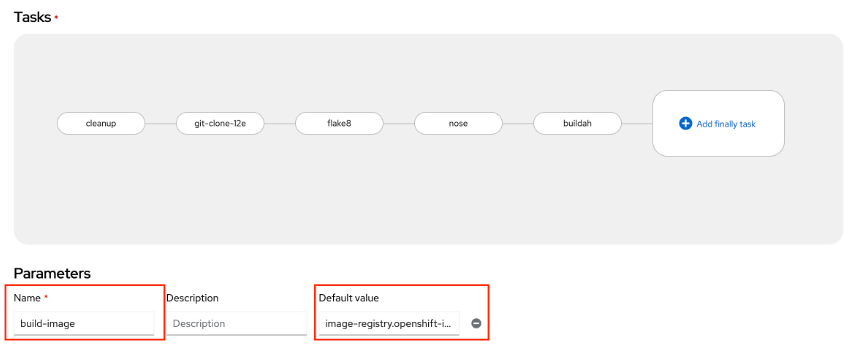


## Check your Solution

If the pipeline ran successfully, you should see all tasks in green in the logs tab. You should also see the output from the `buildah` task indicating all tests have passed successfully.

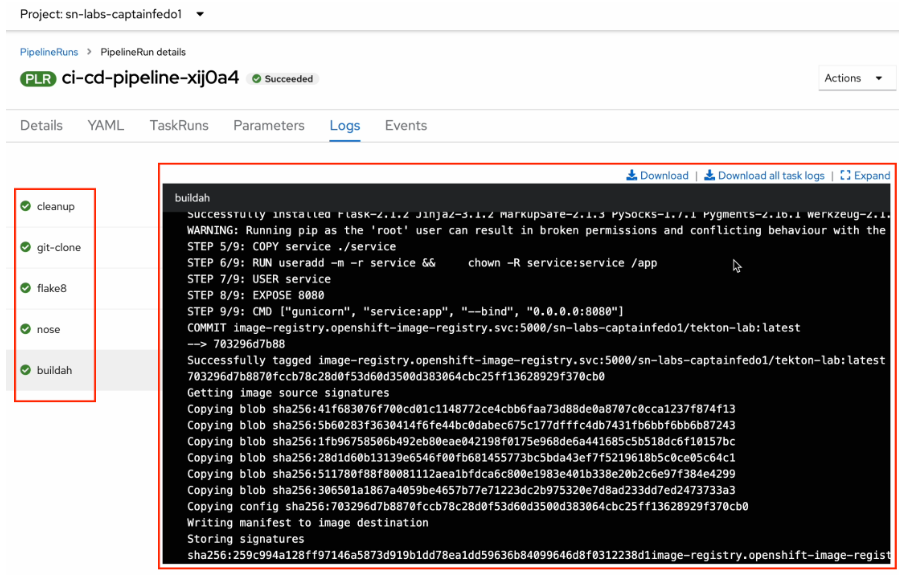

If you complete the task successfully, your pipeline should look as follows:

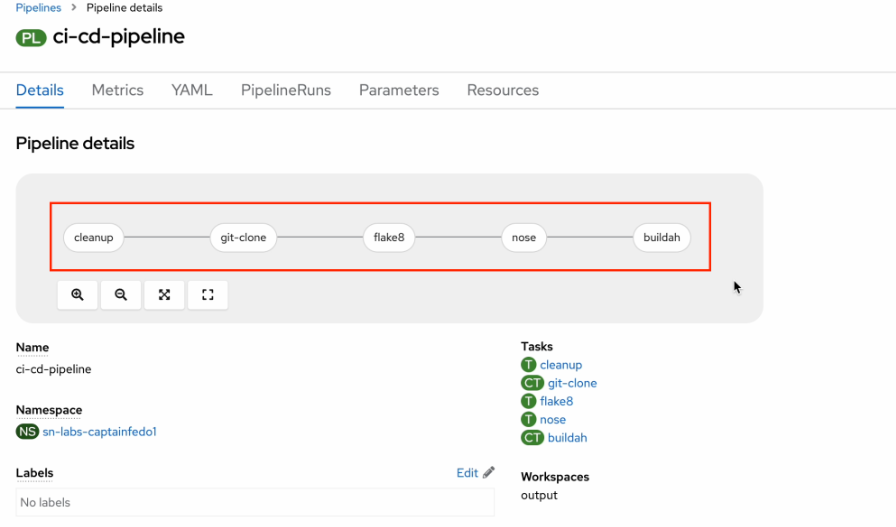

# Step 9: Deploy Application

Next, you will create a task to deploy the image you created to the lab OpenShift cluster. You will use the `OpenShift client` task to execute the `oc deploy` command with the image you built in the previous step.

## Your Task

1. Open the pipeline in edit mode.
2. Add a new task after the buildah task in the pipeline from the previous step.
3. Look for the `openshift-client` task from RedHat.
4. Install and add it to the placeholder task.
5. Click on the red exclaimation on the task or the task card to open the configure task flyout. Configure the task with the following
    * **display name:** `deploy`
    * **SCRIPT:** `oc create deployment $(params.app-name) --image=$(params.build-image) --dry-run=client -o yaml | oc apply -f -`
6. Click on the main page to close the flyout. Add the following parameter and the default value to the pipeline:
    * **parameter.name:** `app-name`
    * **parameter.default:** `cicd-app`
7. Save the pipeline.
8. Run the pipeline.
9. Check the logs to see if there are issues with the pipeline.

## Hint

Ensure the parameter is set as follows:

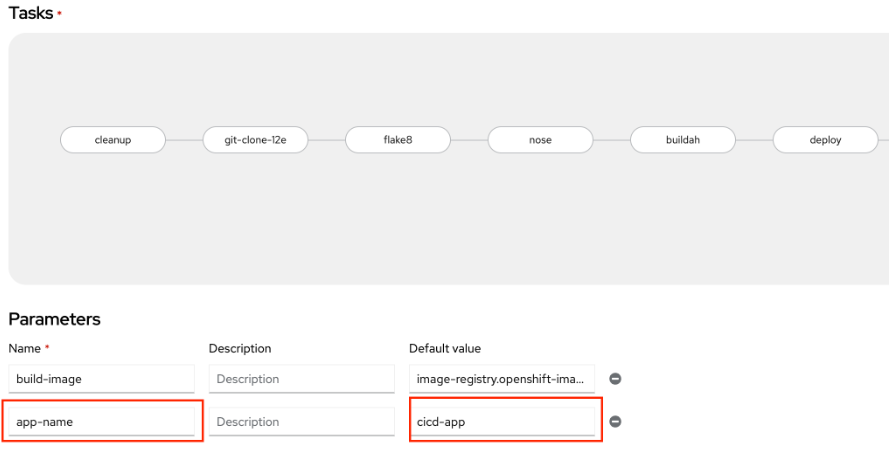


## Check your Solution

If the pipeline ran successfully, you should see all tasks in green in the logs tab. You should also see the output from the `deploy` task indicating all tests have passed successfully.

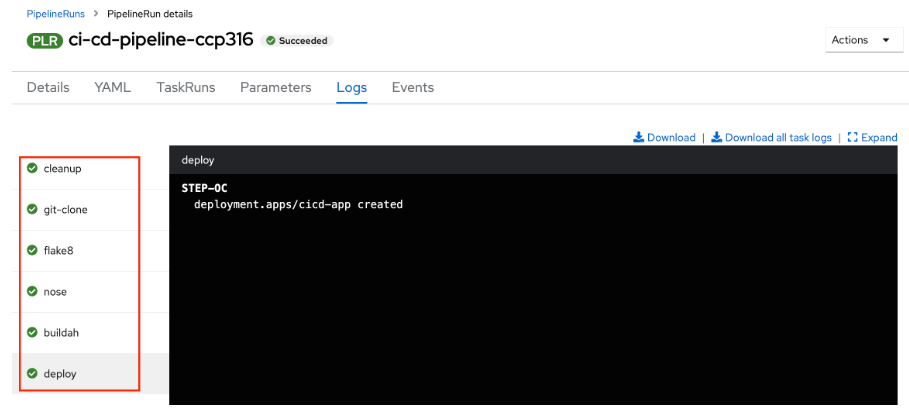

If you complete the task successfully, your pipeline should look as follows:

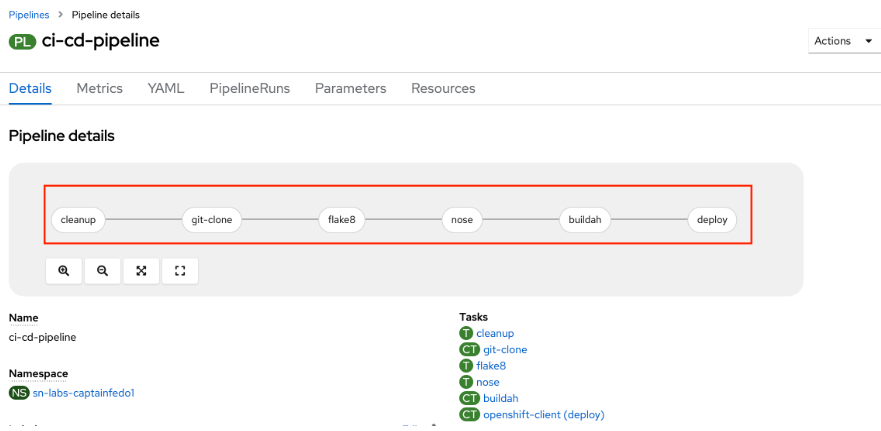

# Step 10: Validate Application

You have done all the hard work! Let's confirm if the application was deployed.

## Your Tasks

1. Click on `Topology` on the left panel in the `Developer perspective. You should see two applications on the canvas.

    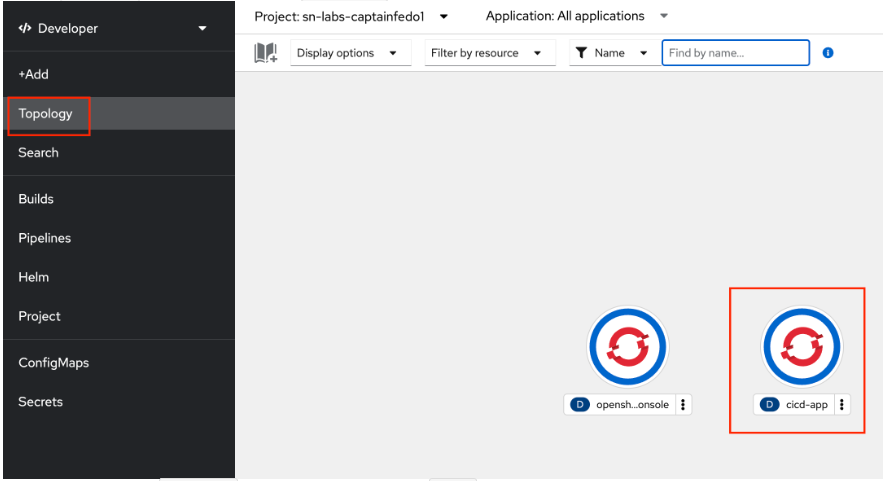

2. Click on the one called `cicd-app` to open the flyout. Click on `logs`.

    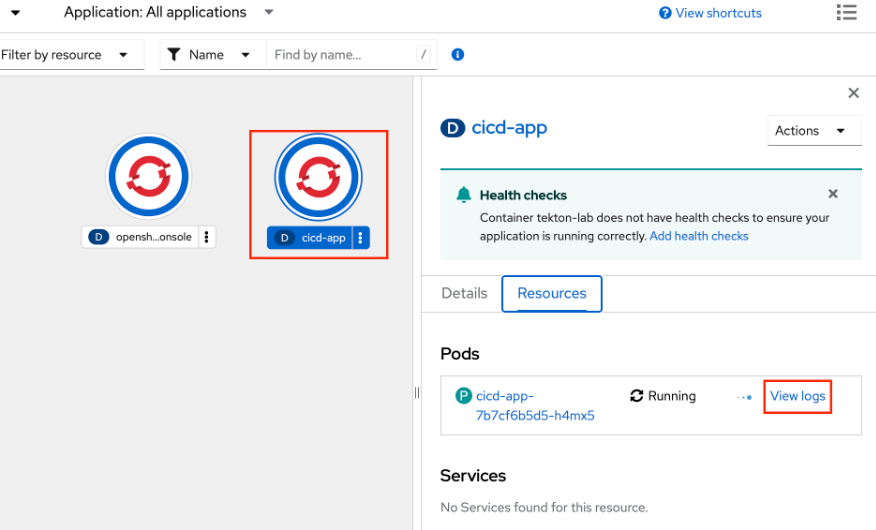

3. You should see a message `SERVICERUNNING` in the logs indicating the application was deployed successfully and is running.

    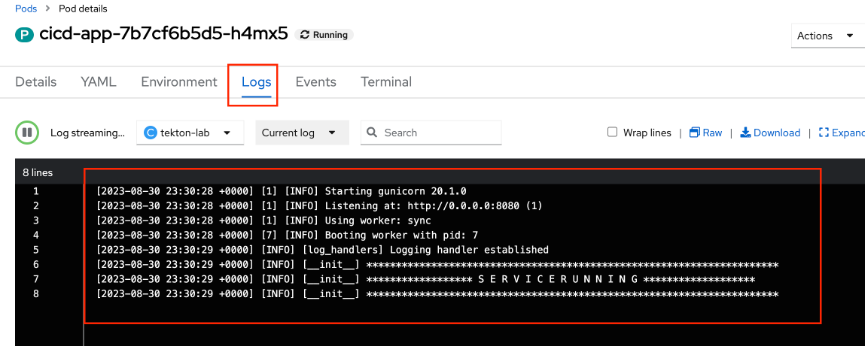


# Conclusion

**Congratulations!** 

You have just created a CI/CD workflow using OpenShift Pipelines without writing a single line of code!

In this lab, you learned how to use the OpenShift UX and the Pipelines feature. You learned how to install the task locally using the Tekton CLI and how to modify your pipeline in the UX to reference the task and configure its parameters. You also learned how to create default parameters for your pipeline. Finally, you now know how to create a PersistentVolumeClaim using the UX.